In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
import imageio
import os
import csv
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms

# 7장 - 새와 비행기 구별하기: 이미지 학습

In [3]:
# 이미지를 다루어 신경망에 대한 기초 다지기

## 1절 - 작은 이미지를 모아 놓은 데이터셋

In [4]:
# CIFAR-10은 32*32 크기의 RGB 이미지 6만 개로 구성되며 0~9까지의 정수로 레이블링
# 0부터 비행기, 자동차, 새, 고양이, 사슴, 강아지, 개구리, 말, 배, 트럭
# 연구 개발이나 검증으로 사용하기에는 단순하지만 학습용으로는 좋음
# 데이터셋 내려받고 텐서 컬렉션으로 읽기 위해 torchvision 모듈 사용
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # 훈련 데이터용 데이터 객체 생성 데이터 없으면 파이토치가 알아서 다운로드
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True) # train=False로 검증용 데이터 얻음 필요시 다운로드

100%|██████████| 170498071/170498071 [00:02<00:00, 82744374.76it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


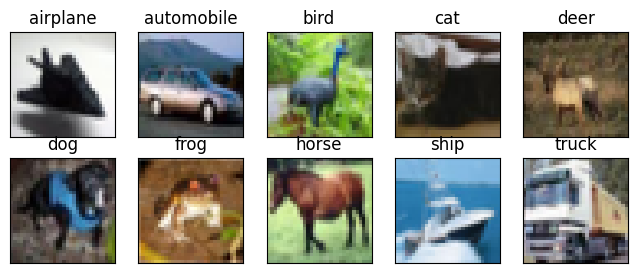

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [6]:
# CIFAR10 함수의 첫 번째 인자는 데이터 받을 위치, 두 번째 인자는 훈련셋인지 검증셋인지 지정, 세 번째 인자는 데이터 못 찾으면 다운받을지 여부 확인

In [7]:
# datasets 서브모듈은 MNIST, Fashion_MNIST, CIFAR-100, SVHN, Coco, Omniglot 등 가장 인기 있는 컴퓨터 비전 데이터셋에 짜여진 절차에 따라 접근할 수 있음
# 각 경우에 데이터셋은 torch.untils.data.Dataset의 서브클래스로 반환됨
# cifar10 인스턴스 메소드 분석하면 기본 클래스로 포함된 것 확인 가능
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [8]:
# torch.utils.data.Dataset의 서브클래스가 된다는 의미는?

In [9]:
# Dataset은 __len__과 __getitem__을 구현하기 위해 필요한 객체
# __len__은 데이터셋의 아이템 수 반환, __getitem__은 샘플과 레이블(정수 인덱스)로 이루어진 아이템 반환

In [10]:
# 실제 사용시 __len__ 메소드 구현된 파이썬 객체라면 파이썬의 내장 함수인 len의 인자로도 사용 가능
len(cifar10)

50000

In [11]:
# 데이터셋에 __getitem__ 메소드 구현되어 있으므로 개별 아이템에 접근할 때 표준 서브스크립트(subscript)에 해당하는 색인용 튜플과 리스트 사용 가능
# 자동차에 해당하는 정수값이 1인 PIL(파이썬 이미지 라이브러리) 형식의 이미지를 얻는 코드
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

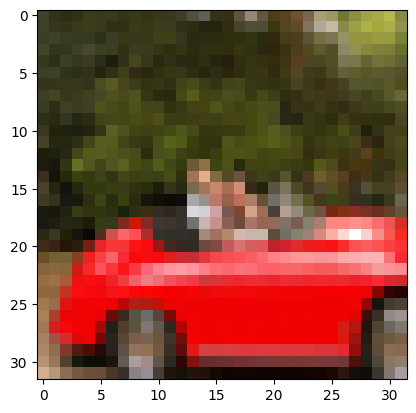

In [12]:
# data.CIFAR10 데이터셋 샘플은 RGB PIL 이미지 객체라서 바로 그려볼 수 있음
plt.imshow(img)
plt.show()

In [13]:
# PIL 이미지를 파이토치 텐서로 변환하기 위해 torchvision.transforms가 필요
# 재구성 가능한 함수 형태의 여러 객체를 정의하고 있어 datasets.CIFAR10(...) 같은 torchvision 데이터셋에 인자로 전달 가능하고 로드한 다음 __getitem__가 결과 반환하기 전 변환 수행함
# 아래는 사용 가능한 객체들
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [14]:
# 이 중 ToTensor는 넘파이배열과 PIL 이미지를 텐서로 바꾸는 역할
# 출력 텐서의 차원 레이아웃을 C*H*W로 맞춰줌
# ToTensor 변환 사용, 객체로 만들면 PIL 이미지를 인자로 함수처럼 호출할 수 있고 텐서 리턴함
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [15]:
# 이미지가 3*32*32 텐서로 변홨됐고 RGB 세 개 채널 가지는 32*32 이미지 됨
# label은 변동 없이 정수

In [16]:
# 변환 자체를 dataset.CIFAR10의 인자로 전달하는 것도 가능
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [17]:
# 데이터셋 요소를 접근하면 PIL 이미지가 아닌 텐서를 리턴함
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [18]:
# 채널은 첫 번째 차원에 있고 스칼라 값은 float32
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [19]:
# 원본 PIL 이미지 값은 0~255(채널당 8비트) 범위인 반면 ToTensor 변환으로 데이터가 채널당 32비트 부동소수점 형태가 되면서 값이 0.0~1.0 사이로 줄어듬
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

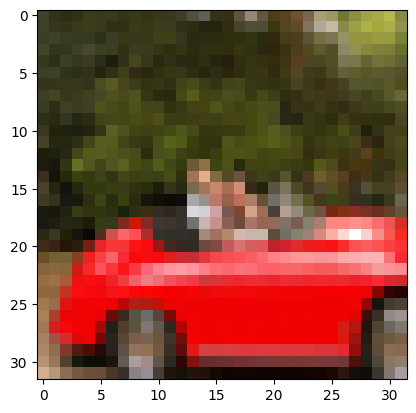

In [20]:
# 동일한 이미지인지 확인
plt.imshow(img_t.permute(1, 2, 0)) # Matplotlib이 기대하는 H*W*C 형태를 위해 permute 사용하였음
plt.show()

In [21]:
# transforms.Compose로 여러 변환 엮어서 사용하면 유용함
# 정규화와 데이터 증강(augmentation)도 데이터 로딩과 같이 수행 가능
# 모든 채널이 평균값 0, 단위 표준편차 가지도록 계산해서 변환 적용하는 것이 transforms.Normalize가 하는 일(mean과 stdev는 계산해주지 않으므로 따로 계산해야 함)

In [22]:
# CIFAR-10 훈련셋으로 계산
# CIFAR-10 데이터셋은 크기가 작기 때문에 필요한 모든 변환을 메모리 내에서 전부 가능
# 추가 차원 만들어 데이터셋이 반환하는 모든 텐서 쌓기
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim = 3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [23]:
# 채널별로 평균 계산
imgs.view(3, -1).mean(dim=1) # view(3, -1) 세 채널은 유지하고 나머지 차원을 적절한 하나로 합침

tensor([0.4914, 0.4822, 0.4465])

In [24]:
# 표준편차 계산
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [25]:
# Normalize 변환 초기화
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [26]:
# ToTensor 변환에 이어붙이기
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]))

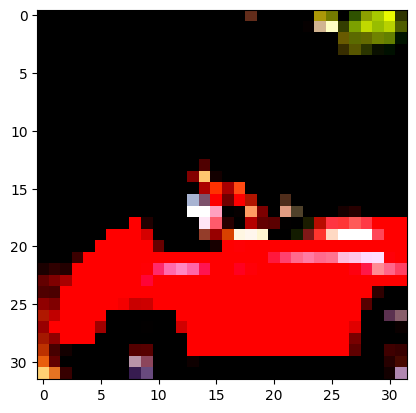

In [27]:
# 정규화가 RGB 값 범위와 채널값의 범위도 바꿔서 원본 이미지와 다름
# 값이 바뀌어도 데이터는 존재하며 matplotlib이 검은색으로 그릴 뿐임
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## 2절 - 새와 비행기 구별하기

In [28]:
# 데이터의 차원 정보 맞추기
# 새와 비행기만 들어간 Dataset 서브 클래스 만드는데 데이터셋이 작고 인덱싱과 len만 있으면 되므로 torch.utils.dataset.Dataset의 서브클래스일 필요는 없음
# cifar10에 있는 데이터 필터링하고 레이블 재매핑해서 연속적으로 만들기
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]

In [29]:
# cifar2 객체는 __len__과 __getitem__이 정의되어 있으므로 Dataset의 기본 요구사항을 만족함
# 제한 걸리는 경우에는 Dataset 만드는 편이 나음

In [30]:
# 이미지 픽셀을 받아서 긴 1차원 벡터로 늘어뜨리고 일련의 숫자들을 입력 피처로 보기
# 32*32*3 이므로 샘플당 3072개의 입력 피처 존재
# 새 모델은 nn.Linear이면서 입력 피처 2072, 몇 개의 히든 피처 거쳐 활성 함수로 이어지도록 설계
# 이후 다른 nn.Linear로 신경망 줄여나가면서 원하는 출력 피처 수로 맞추기(이 경우에는 2)
import torch.nn as nn
n_out = 2

model = nn.Sequential(nn.Linear(3072, 512, ), # 임의로 은닉 피처 512로 설정
                      nn.Tanh(),
                      nn.Linear(521, n_out, ))

In [31]:
# 신경망은 최소 하나 이상의 비선형성 가진 은닉층(활성 함수 포함하므로 두 개의 모듈)이 필요
# 은닉된 피처는 가중치 행렬로 인코딩된 입력값들 간의 학습된 관계 나타냄

In [32]:
# 신경망이 단일한 스칼라값(n_out = 1)을 출력하게 만들고 레이블을 float로 변환 후 MSELoss의 타깃으로 사용하여 회귀 문제로 만들기
# 하지만 출력값이 카테고리값이므로 원핫 인코딩으로 바꿔야 함
# CIFAR-10 전체 데이터셋에 대한 클래스 사용하는 경우도 마찬가지로 길이 10인 벡터로 원핫 인코딩

In [33]:
# 이상적인 경우 신경망은 비행기에 대해 torch.tensor([1.0, 0.0]) 출력하고 새에 대해 torch.tensor([0.0, 1.0]) 출력
# 실제로는 완벽하지 않아 신경망의 출력은 두 값 사이로 나올 것이고 이를 확률로 해석하기
# ㄴ 이 경우 출력에 추가적인 제약 수반 1. 출력값의 범위는 [0.0, 1.0] / 2. 모든 출력 요소의 합은 1.0(결과는 항상 새 or 비행기)
# 제약 극복하면서 미분 가능하게 만드는 소프트맥스(softmax)

In [34]:
# 소프트맥스는 벡터의 각 요소 단위로 지수 연산 후 각 요소를 지수 값의 총합으로 나눔
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [35]:
# 테스트
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [36]:
# 확률 제한사항 만족 여부
softmax(x).sum()

tensor(1.)

In [37]:
# 소프트맥스는 단조 함수라서 입력값이 낮아지면 출력값도 낮아지지만 범위는 맞춰주지 않아 각 값들 간에 비율이 유지되지 않음
# 실제로는 모델 파라미터가 학습 과정을 통해 값이 적당한 비율로 맞춰지도록 정해지므로 큰 문제 안 됨

In [38]:
# nn 모듈은 소프트맥스를 모듈처럼 사용할 수 있게 해줌
# 통상적으로 입력 텐서는 0번 차원이 배치에 해당하거나 확률 값을 특정 차원에 대해서만 인코딩 하므로 nn.Softmax는 적용할 차원을 지정하도록 요구함
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [39]:
# 모델 끝에 소프트맥스 추가하기
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.Softmax(dim=1))

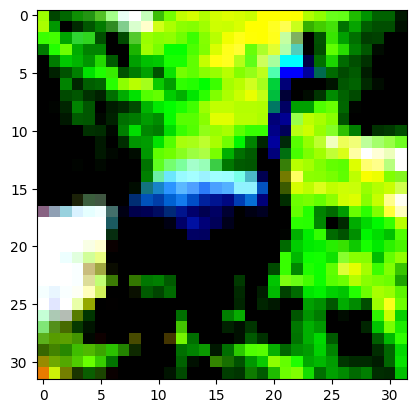

In [40]:
# 새 이미지 하나로 단일 이미지 배치 만들어 훈련시키기 전에 결과 확인
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0)) # 오류남(원인: cifar2 만들 때 cifar10이 아닌 transformed_cifar10에서 가져와야 됨)
plt.show()

In [41]:
# 입력 차원 맞아야 하므로 3*32*32 이미지를 1차원 텐서로 만들고 추가 차원을 0번 포지션에 넣어야 함
img_batch = img.view(-1).unsqueeze(0)

In [42]:
# 모델 호출
out = model(img_batch)
out

tensor([[0.3671, 0.6329]], grad_fn=<SoftmaxBackward0>)

In [43]:
# 지금은 어떤 확률값이 어떤 클래스를 의미하는지 알고 있지만 신경망에서는 이를 표시하지 않음
# 두 숫자값에 역전파 후 이런 의미를 부여하는 것은 활성 함수임
# 레이블에서 0번 인덱스가 비행기 1번 인덱스가 새로 주어졌다면 이게 출력값이 의미하는 순서가 됨
# 이를 가지고 훈련 후에 출력된 확률에 대해 argmax 연산으로 레이블 얻어낼 수 있음
# 차원이 주어지는 경우 torch.max는 해당 차원에서 가장 높은 요소와 인덱스 리턴

In [44]:
# 배치를 가로지르는 대신 확률 벡터 내에서 최댓값 찾아야 함
_, index = torch.max(out, dim=1)
index

tensor([1])

In [45]:
# 비행기에 대해서는 첫 번째 확률이 높게, 새에 대해서는 두 번째 확률이 높게 나오는 것이 중요
# 0.0이나 1.0이 아닌 모든 경우를 벌점주는 것이 아닌 분류가 어긋날 경우 벌점 주는 식으로 훈련을 원함

In [46]:
# out이 소프트맥스의 출력이면서 class_index가 비행기일 때는 0, 새일 때는 1을 포함하는 벡터라고 할 때 정답 클래스 out[class_index]와 관련된 확률 극대화 할 필요성 존재
# 정답 클래스에 대한 확률 수치를 가능도(likelihood)라고 함
# 가능도가 낮을 때(다른 클래스의 확률이 매우 높을 때) 값이 커지는 손실 함수 필요

In [47]:
# NLL(Negative Log Likelihood) 함수는 NLL = - sum(log(out_i[c_i]))로 표현되며 sum은 N개의 샘플 합, c_i는 샘플 i에 대한 정답 클래스
# 낮은 확률 주어지면 무한으로 늘어나며 0.5 이상의 확률 주어지면 완만하게 감소
# NLL은 확률을 입력받으므로 가능도가 증가하면 다른 확률은 필연적으로 줄어듦

In [48]:
# 분류를 위한 손실 계산 요약. 배치 내의 각 샘플에 대해
# 1. 순방향 전달 후 마지막 선형 계층에서 출력값 받음
# 2. 이들의 소프트맥스 값 계산하여 확률 얻음
# 3. 파라미터의 가능도에 해당하는 정답 클래스와 일치하는 예측 확률값 얻음 (지도(supervised) 문제라 실측값이 존재하므로 정답 클래스 알고 있음)
# 4. 로그값 계산해서 앞에 마이너스 붙인 다음 손실값에 더하기

In [49]:
# 파이토치는 nn.NLLLoss 클래스 제공
# 로그 확률의 텐서를 받고 데이터 배치에 대한 모델의 NLL을 계산
# 확률의 로그값을 받으면 확률이 0에 가까울 경우 문제 발생하는데 이를 해결하기 위해 nn.LogSoftmax 사용하여 계산 수행 안정화시킴

In [50]:
# nn.LogSoftmax를 출력 모듈로 사용하도록 모델 수정
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

In [51]:
# NLL 손실값 초기화
loss = nn.NLLLoss()

In [52]:
# 손실값은 배치에 대한 nn.LogSoftmax 출력을 첫 번째 인자로 받고 클래스 인덱스(여기서는 여러 개의 0이나 1) 텐서를 두 번째 인자로 받음
# 새로 테스트
img,labe = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.5146, grad_fn=<NllLossBackward0>)

In [53]:
# 손실값을 알아보니 크로스엔트로피 손실이 MSE보다 얼마나 개선되었는지 확인 가능
# 크로스엔트로피는 예측이 타겟에서 멀어지면 경사가 적당히 생기지만 MSE는 훨씬 더 일찍 포화되어 좋지 않은 예측을 함
# 근본적으로 MSE의 기울기는 잘못된 예측에 대한 소프트맥스 함수의 평탄화 보상하기에 너무 작이므로 분류 문제에서 확률에 대해 MSE 사용은 좋지 못 함

In [54]:
# 5장에서 작성한 훈련 루프 가져와서 어떻게 훈련할지 확인
"""
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr = learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss %f" % (epoch, float(loss)))"""

'\nmodel = nn.Sequential(nn.Linear(3072, 512),\n                      nn.Tanh(),\n                      nn.Linear(512, 2),\n                      nn.LogSoftmax(dim=1))\n\nlearning_rate = 1e-2\n\noptimizer = optim.SGD(model.parameters(), lr = learning_rate)\nloss_fn = nn.NLLLoss()\n\nn_epochs = 100\n\nfor epoch in range(n_epochs):\n    for img, label in cifar2:\n        out = model(img.view(-1).unsqueeze(0))\n        loss = loss_fn(out, torch.tensor([label]))\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    print("Epoch: %d, Loss %f" % (epoch, float(loss)))'

In [55]:
# 5장에서는 에포크 전체에 하나의 루프가 있었지만 지금은 단일 배치에 1만 개의 이미지를 모두 평가하는 것은 너무 많으므로 내부 루프 안에서 한 번에 하나의 샘플을 평가하고 단일 샘플에 대해 역전파 해보기

In [56]:
# 그림 7.12
# 1. 모든 데이터셋에 대한 평균으로 조정
# 2. 각 샘플마다 모델을 조정
# 3. 미니 배치마다 평균 구해서 조정

In [57]:
 # 1의 경우 기울기 값은 적용하기 전 모든 샘플로부터 값이 누적되지만 지금은 단일 샘플에서 부분적으로 기울기를 얻어 파라미터 변경
 # 하나의 샘플에 기반해서 손실값을 줄이는 건 다른 샘플에 대해서 안 좋아진 것일 수 있음
 # 따라서 각 에포크마다 샘플을 섞은 후 한 번에 하나 혹은 여러 개의 샘플에 대해 기울기를 평가하면 경사 하강에 랜덤한 효과 넣을 수 있음
 # SGD의 S는 확률적이라는 의미로서, 섞은 데이터의 작은 배치(미니 배치) 단위로 수행
 # 미니 배치에서 얻은 기울기 사용하면 전체 데이터셋에 대한 값만큼 근사하지는 않지만 훈련 중 만날 수 있는 지역 최솟값에 빠지는 것을 예방하고 수렴 돕는 것으로 알려져 있음
 # 미니 배치에서의 기울기는 이상적인 궤적에서 랜덤하게 떨어져 있으므로 작은 학습률을 사용
 # 각 에포크에서 데이터셋을 섞으면 미니 배치에서 얻은 기울기의 시퀀스가 전체 데이터셋에서 계산한 기울기를 대표하게 만드는 데 도움이 됨

In [58]:
# 통상 미니 배치 크기는 학습률 지정한 것과 같이 훈련 전에 상수로 고정함
# 이러한 고정 값들을 모델의 파라미터와 구분해 하이퍼파라미터라고 부름

In [59]:
# 위의 훈련 코드는 데이터셋에서 한 번에 하나의 아이템을 골라 크기가 1인 미니 배치를 만듦
# torch.utils.data 모듈에는 미니 배치의 데이터를 섞거나 구조화하는 작업을 돕는 DataLoader 클래스 존재
# 데이터 로더를 활용해 데이터셋에서 미니 배치에 포함될 샘플 가져올 때 여러 샘플링 전략 중 하나 고를 수 있음
# 가장 흔한 전략은 각 에포크마다 데이터 섞은 후 고르게 샘플링하는 것

In [60]:
# DataLoader 생성자는 입력으로 Dataset 객체와 batch_size와 shuffle 입력받음
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [61]:
# DataLoader는 순회 가능하므로 새로운 훈련 코드의 루프 안에 바로 넣어 사용 가능함
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.522680
Epoch: 1, Loss: 0.574350
Epoch: 2, Loss: 0.540593
Epoch: 3, Loss: 0.185105
Epoch: 4, Loss: 0.282776
Epoch: 5, Loss: 0.478368
Epoch: 6, Loss: 0.395844
Epoch: 7, Loss: 0.318405
Epoch: 8, Loss: 0.347466
Epoch: 9, Loss: 0.344811
Epoch: 10, Loss: 0.493193
Epoch: 11, Loss: 0.316091
Epoch: 12, Loss: 0.551514
Epoch: 13, Loss: 0.508665
Epoch: 14, Loss: 0.251122
Epoch: 15, Loss: 0.168925
Epoch: 16, Loss: 0.428849
Epoch: 17, Loss: 0.277137
Epoch: 18, Loss: 1.193977
Epoch: 19, Loss: 0.206307
Epoch: 20, Loss: 0.295561
Epoch: 21, Loss: 0.215119
Epoch: 22, Loss: 0.186260
Epoch: 23, Loss: 0.190230
Epoch: 24, Loss: 0.244132
Epoch: 25, Loss: 0.141460
Epoch: 26, Loss: 0.248593
Epoch: 27, Loss: 0.209514
Epoch: 28, Loss: 0.305199
Epoch: 29, Loss: 0.353549
Epoch: 30, Loss: 0.246346
Epoch: 31, Loss: 0.063571
Epoch: 32, Loss: 0.163263
Epoch: 33, Loss: 0.212483
Epoch: 34, Loss: 0.149389
Epoch: 35, Loss: 0.082319
Epoch: 36, Loss: 0.140096
Epoch: 37, Loss: 0.068967
Epoch: 38, Loss: 0.052

In [62]:
# 루프 내부에서 imgs는 64(32*32) RGB 이미지에 해당하는 크기 64*3*32*32인 텐서이고 labels는 레이블 인덱스 가진 크기 64의 텐서임

In [63]:
# 검증셋으로 모델의 정확도 계산
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy: ", correct / total)

Accuracy:  0.9996


In [64]:
# 모델에 계층을 더 추가하면 모델의 깊이나 용량이 증가함
model = nn.Sequential(nn.Linear(3072, 1024),
                      nn.Tanh(),
                      nn.Linear(1024, 512),
                      nn.Tanh(),
                      nn.Linear(512, 128),
                      nn.Tanh(),
                      nn.Linear(128, 2),
                      nn.LogSoftmax(dim=1))

In [65]:
# nn.LogSoftmax와 nn.NLLLoss 조합은 nn.CrossEntropyLoss와 동일함
# nn.CrossEntropyLoss는 logit이라 불리는 점수를 입력으로 받음
# 구체적으로는 nn.NLLLoss는 타깃에 모든 것을 담아 넣는 디랙 분포와 로그 확률 입력으로 주어지는 예측 분포 사이의 크로스엔트로피라고 볼 수 있음

In [66]:
# 정보 이론 중 샘플 크기로 정규화하는 부분에서 크로스엔트로피는 타깃의 분포에 대한 예측 분포로서 '음의 로그 가능도(negative log likelihood)'로 해석 가능
# 따라서 두 손실값 모두 우리의 모델이 소프트맥스가 적용된 확률을 예측한다고 할 때 주어진 데이터에 대한 모델 파라미터의 음의 로그 가능도라 할 수 있음

In [67]:
# 일반적으로 신경망의 마지막 계층에서는 nn.LogSoftmax 대신 손실값으로 nn.CrossEntropyLoss를 사용함
model = nn.Sequential(nn.Linear(3072, 1024),
                      nn.Tanh(),
                      nn.Linear(1024, 512),
                      nn.Tanh(),
                      nn.Linear(512, 128),
                      nn.Tanh(),
                      nn.Linear(128, 2))
loss_fn = nn.CrossEntropyLoss()

In [68]:
# 숫자가 정확하게 nn.LogSoftmax 및 nn.NLLLoss와 동일함을 확인
# 모델의 출력을 확률 및 로그 확률로 해석 가능하지 못하는 단점이 존재해 이를 구하기 위해 출력을 다시 소프트매긋에 명시적으로 연결할 필요 있음

In [69]:
# 파이토치는 nn.Module의 parameters() 메소드를 통해 모델이 얼마나 많은 파라미터 가지고 있는지 확인 가능
# 각 텐서 객체에 얼마나 많은 요소가 있는지 확인할려면 numel 메소드 사용
# 얻은 값 합산하여 전체 수 파악 가능
# 파라미터 수를 세려면 파라미터에 대해 requires_grad가 True로 설정되어 있어야 함
# 전체 모델 크기 대비 학습 가능한 파라미터의 수는 구별돼야 하기 때문
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [70]:
# 전 모델과 비교
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [71]:
# 선형 계층이 y = weight * x + bias를 가지며 x의 길이가 (배치 차원은 무시하고)3072, y가 1024면 weight 텐서는 1024 * 3072, bias는 1024이므로 1024 * 3072 + 1024 = 3,146,752

In [72]:
# 수치 확인
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [73]:
# 이러한 결과를 통해 신경망이 픽셀 수에 따라 확장 가능하기 어려움을 알 수 있음
# 이미지 크가가 1024 * 1024 RGB인 경우 첫 계층에서 30억 개의 파라미터 가지며 GPU 리소스를 전부 차지함

In [74]:
# 이미지를 1차원으로 놓고 선형 모듈 사용하는 방식(완전 연결)은 입력으로 들어오는 RGB 이미지의 모든 정보를 사용하며 출력 피처 하나하나에 각 정보의 선형 조합을 계산
# 픽셀 하나마다 다른 모든 픽셀과의 조합을 고려하지만 가까운 위치나 먼 위치에 있는 점 사용하지 않고 이미지를 하나의 큰 숫자 벡터로 취급할 뿐
# 인식한 물체가 1 픽셀만 움직여도 인식을 못 함 -> 평행이동 불변성(translation invariance) 없음
# 보안하려면 데이터셋을 증강해야하지만 파라미터에 해당하는 은닉된 피처의 수가  평행이동시킨 복제본에 대한 모든 정보 보관하기 충분할 만큼 커야 되기 때문에 상당한 비용이 필요

## 3절 - 결론

In [75]:
# 간단한 분류 문제 풀어봄
# 데이터셋에서 모델 구성하는 동안 훈련 루프에서 적당한 손실값을 정의하고 최소화 해봄
# 앞으로 파이토치 사용하면 다룰 표준적인 도구들

In [76]:
# 2차원 이미지를 1차원 데이터처럼 취급했는데 평행이동 불변성에 대응 못 함

In [77]:
# 지금까지 배운 걸로 평행이동 불변성 포함하지 않는 경우에 데이터 적용해서 활용 가능

## 4절 - 연습 문제

In [78]:
# 1. torchvision을 사용하여 데이터를 임의로 잘라내보자.
#   a. 원래의 이미지와 비교하여 어떤 점이 다른가
#   b. 동일한 이미지를 다시 처리하면 어떻게 되는가
#   c. 랜덤하게 크롭된 이미지로 훈련시킨 결과는 어떤가

In [88]:
# 문제 이해 못함 뭘 어떻게 자르고 크롭하라고

In [80]:
# 2. 손실 함수를 바꿔보자(아마도 MSE로)
#   a. 훈련 방식이 바뀌는가? 모델 출력 피처 및 계층, labels의 dtype 변환 등이 바뀜

In [81]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 1))

#loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()

n_epochs = 50
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        labels = labels.to(torch.float32)
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 0.278829
Epoch: 1, Loss: 0.251236
Epoch: 2, Loss: 0.250903
Epoch: 3, Loss: 0.249687
Epoch: 4, Loss: 0.252276
Epoch: 5, Loss: 0.250441
Epoch: 6, Loss: 0.250181
Epoch: 7, Loss: 0.248933
Epoch: 8, Loss: 0.244253
Epoch: 9, Loss: 0.250174
Epoch: 10, Loss: 0.248414
Epoch: 11, Loss: 0.252678
Epoch: 12, Loss: 0.249764
Epoch: 13, Loss: 0.250134
Epoch: 14, Loss: 0.251216
Epoch: 15, Loss: 0.251323
Epoch: 16, Loss: 0.243053
Epoch: 17, Loss: 0.247671
Epoch: 18, Loss: 0.250118
Epoch: 19, Loss: 0.233909
Epoch: 20, Loss: 0.250994
Epoch: 21, Loss: 0.250836
Epoch: 22, Loss: 0.249211
Epoch: 23, Loss: 0.251927
Epoch: 24, Loss: 0.250511
Epoch: 25, Loss: 0.251674
Epoch: 26, Loss: 0.250319
Epoch: 27, Loss: 0.250420
Epoch: 28, Loss: 0.249976
Epoch: 29, Loss: 0.250141
Epoch: 30, Loss: 0.249266
Epoch: 31, Loss: 0.250902
Epoch: 32, Loss: 0.251128
Epoch: 33, Loss: 0.252563
Epoch: 34, Loss: 0.251435
Epoch: 35, Loss: 0.251527
Epoch: 36, Loss: 0.250687
Epoch: 37, Loss: 0.249405
Epoch: 38, Loss: 0.248

In [87]:
# 3. 과적합이 일어나지 않을 정도로 신경망의 용량을 줄이는 것이 가능한가? # Colab GPU 할당 이슈로 못함
#   a. 이럴 경우 검증셋에서의 모델 성능은 어떠한가? # 과적합 일어나지 않았으므로 성능 향상할 것으로 예상됨

In [85]:
# training
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(nn.Linear(3072, 1024),
                      nn.Tanh(),
                      nn.Linear(1024, 512),
                      nn.Tanh(),
                      nn.Linear(512, 128),
                      nn.Tanh(),
                      nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_epochs = 50

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.356584
Epoch: 1, Loss: 0.484403
Epoch: 2, Loss: 0.566647


KeyboardInterrupt: 

In [ ]:
# validation
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy: ", correct / total)